In [2]:
# Test your Gemini API
import google.generativeai as genai

# You'll enter your API key when prompted
api_key = input("Enter your Gemini API key: ")
genai.configure(api_key=api_key)

model = genai.GenerativeModel('gemini-pro')
# models = genai.list_models()
# print([m.name for m in models])

model = genai.GenerativeModel("models/gemini-2.5-pro")
#response = model.generate_content("Say hello to MGMT 599!")
#print(response.text)

Enter your Gemini API key: ****


In [3]:
# 1. Install / upgrade the BigQuery client (you can skip if already installed)
!pip install --upgrade google-cloud-bigquery pandas --quiet

# 2. Authenticate your Google account
from google.colab import auth
auth.authenticate_user()

# 3. Import BigQuery client and pandas
from google.cloud import bigquery
import pandas as pd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 68.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [4]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import auth
from google.cloud import bigquery
import google.generativeai as genai

In [5]:
client = bigquery.Client(project="mgmt599-sainuka-lab1")
table_id = "mgmt599-sainuka-lab1.lab1_eda.superstore_dataset"

# Test connection and get schema
table = client.get_table(table_id)
schema_prompt = []
for field in table.schema:
    schema_prompt.append(f"- {field.name} ({field.field_type})")
print("Schema for BigQuery table:")
print("\n".join(schema_prompt))

Schema for BigQuery table:
- order_id (STRING)
- order_date (DATE)
- ship_date (DATE)
- customer (STRING)
- manufactory (STRING)
- product_name (STRING)
- segment (STRING)
- category (STRING)
- subcategory (STRING)
- region (STRING)
- zip (INTEGER)
- city (STRING)
- state (STRING)
- country (STRING)
- discount (FLOAT)
- profit (FLOAT)
- quantity (INTEGER)
- sales (FLOAT)
- profit_margin (FLOAT)


In [6]:
# Load complete dataset
query_load = f"""
SELECT *
FROM `{table_id}`
"""
df = client.query(query_load).to_dataframe()

# Display basic info
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())
print("\nRegional distribution:")
print(df['region'].value_counts())


Dataset shape: (9994, 19)

Column names: ['order_id', 'order_date', 'ship_date', 'customer', 'manufactory', 'product_name', 'segment', 'category', 'subcategory', 'region', 'zip', 'city', 'state', 'country', 'discount', 'profit', 'quantity', 'sales', 'profit_margin']

Regional distribution:
region
West       3203
East       2848
Central    2323
South      1620
Name: count, dtype: int64


In [7]:
# Initial Question
# How do the four regions rank in terms of profit performance, and what are their basic profit metrics
query_basic = f"""
SELECT
    region,
    SUM(profit) as total_profit,
    COUNT(*) as total_orders,
    AVG(profit) as avg_profit_per_order
FROM `{table_id}`
GROUP BY region
ORDER BY total_profit DESC
"""

regional_basic = client.query(query_basic).to_dataframe()

# Visualize regional profit
fig = px.bar(regional_basic, x='region', y='total_profit', title='Total Profit by Region')
fig.show()

fig = px.bar(regional_basic, x='region', y='avg_profit_per_order', title='Average Profit per Order by Region')
fig.show()

In [8]:
prompt_first_impressions = f"""
I just ran a simple query to analyze regional profit performance for a Superstore dataset.

Here are the results:
{regional_basic.to_string(index=False)}

As a business analyst seeing this data, please provide your first impressions:
"""

# Get Gemini first impressions
response = model.generate_content(prompt_first_impressions)

#print("Gemini first impressions:")
#print("=" * 50)
#print(response.text)
#print("=" * 50)

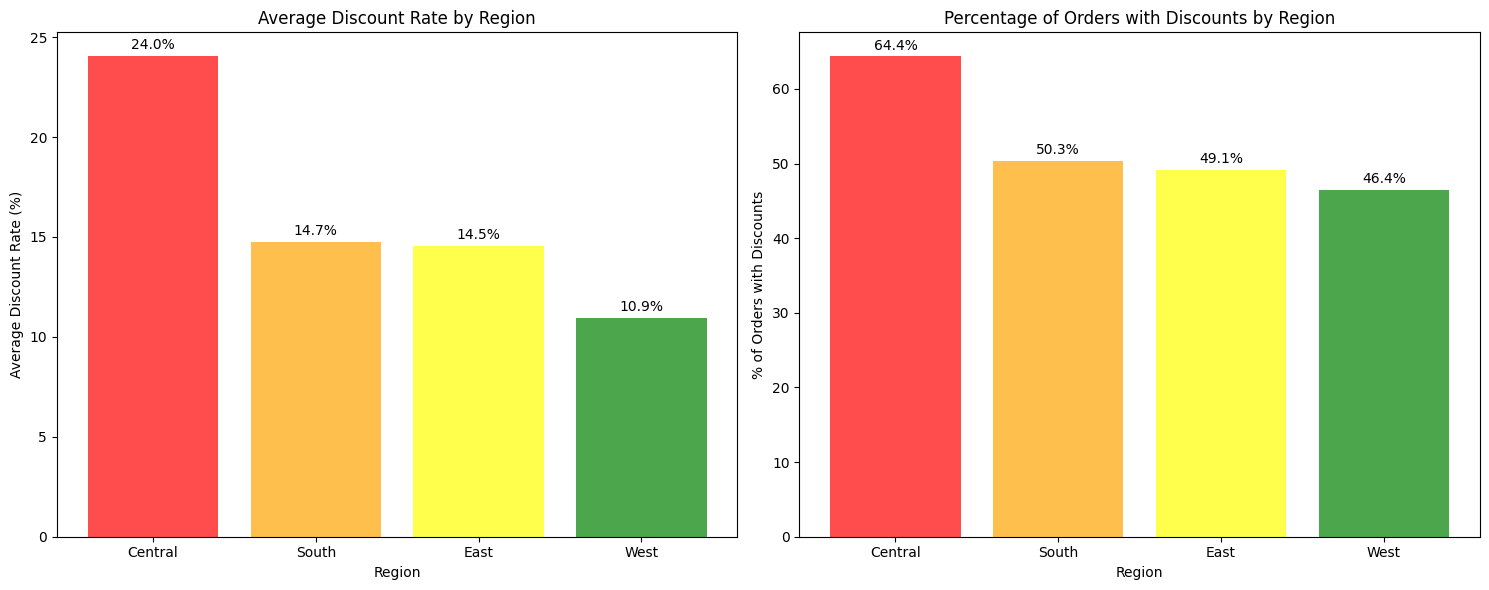

In [9]:
# Analyze Average Discount by Region

query_discount = f"""
SELECT
    region,
    AVG(discount) as avg_discount_rate,
    COUNT(*) as total_orders,
    SUM(CASE WHEN discount > 0 THEN 1 ELSE 0 END) as discounted_orders,
    SUM(CASE WHEN discount > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*) as discount_percentage
FROM `{table_id}`
GROUP BY region
ORDER BY avg_discount_rate DESC
"""

discount_by_region = client.query(query_discount).to_dataframe()

# Visualization 1: Average Discount Rate by Region
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of average discount rates
ax1.bar(discount_by_region['region'], discount_by_region['avg_discount_rate'] * 100,
        color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
ax1.set_title('Average Discount Rate by Region')
ax1.set_ylabel('Average Discount Rate (%)')
ax1.set_xlabel('Region')
for i, v in enumerate(discount_by_region['avg_discount_rate'] * 100):
    ax1.text(i, v + 0.2, f'{v:.1f}%', ha='center', va='bottom')

# Bar chart of discount percentage (% of orders with discounts)
ax2.bar(discount_by_region['region'], discount_by_region['discount_percentage'],
        color=['red', 'orange', 'yellow', 'green'], alpha=0.7)
ax2.set_title('Percentage of Orders with Discounts by Region')
ax2.set_ylabel('% of Orders with Discounts')
ax2.set_xlabel('Region')
for i, v in enumerate(discount_by_region['discount_percentage']):
    ax2.text(i, v + 0.5, f'{v:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


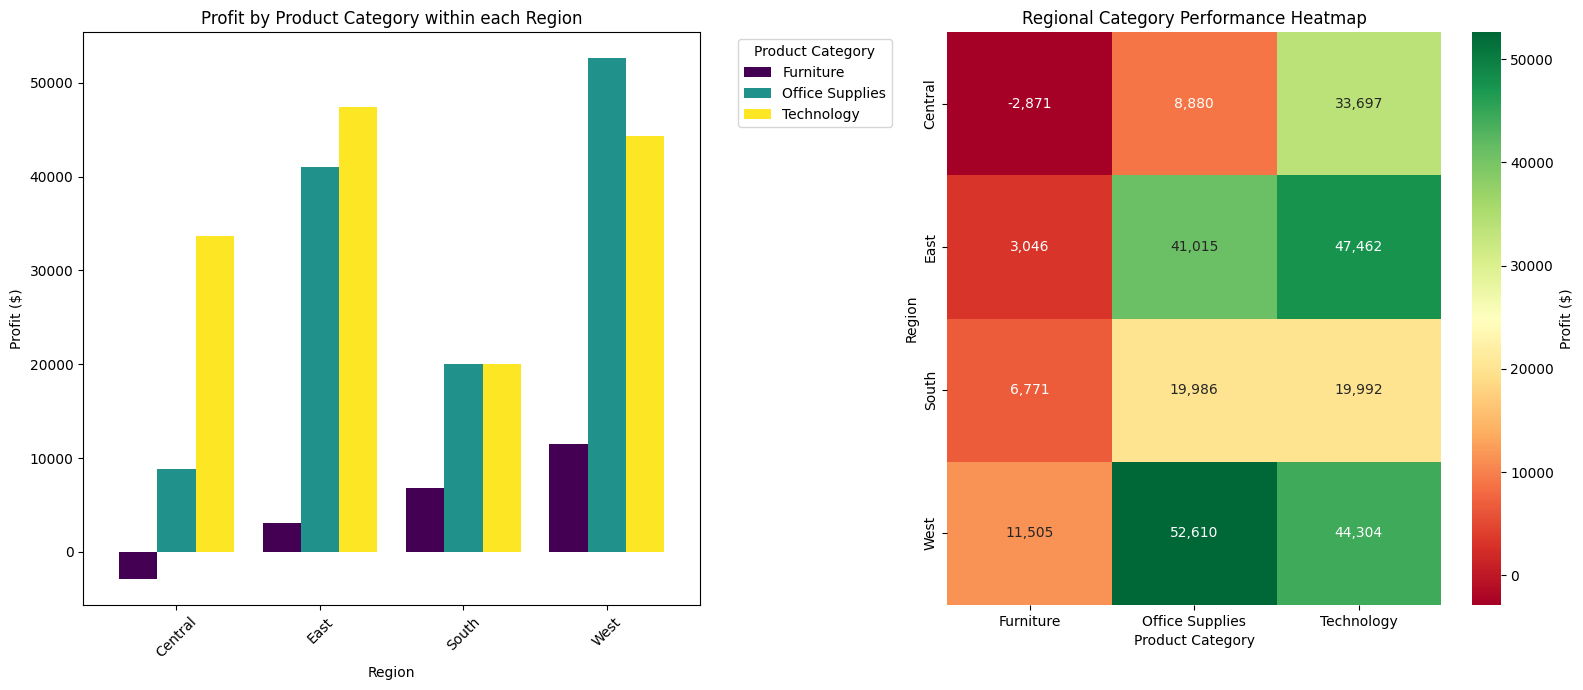

<Figure size 1200x600 with 0 Axes>

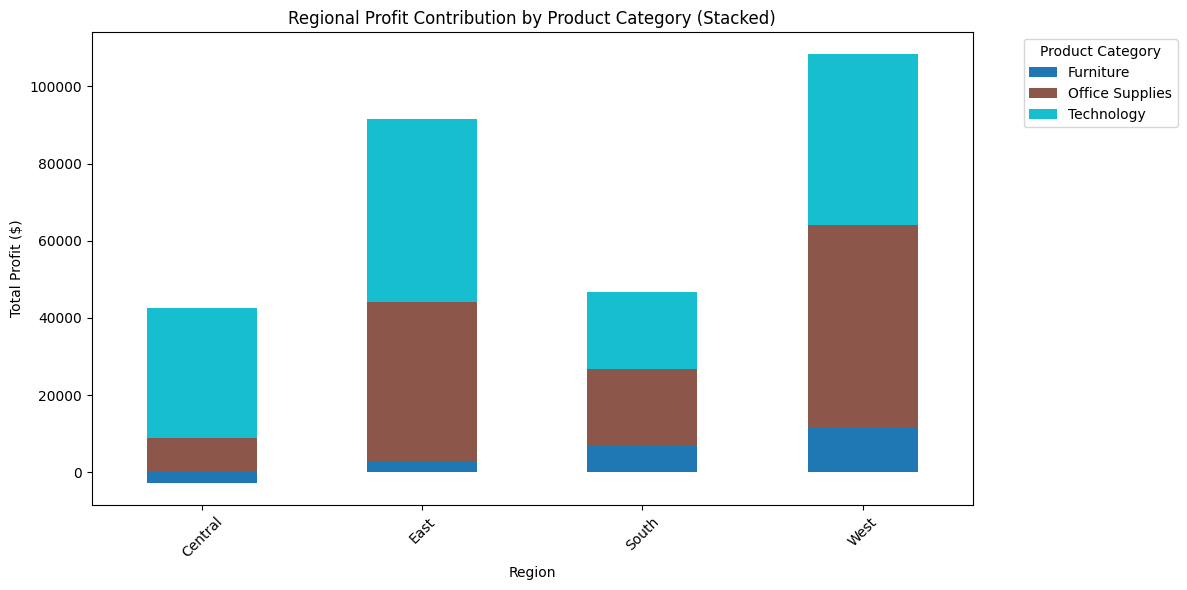

In [ ]:
# Analyze Profit by Product Category within each Region

query_category = f"""
SELECT
    region,
    category,
    SUM(profit) as category_profit,
    COUNT(*) as orders,
    AVG(profit) as avg_profit_per_order,
    SUM(sales) as category_sales
FROM `{table_id}`
GROUP BY region, category
ORDER BY region, category_profit DESC
"""

category_by_region = client.query(query_category).to_dataframe()

# Create a pivot table for better visualization
category_pivot = category_by_region.pivot(index='region', columns='category', values='category_profit')

# Visualization 2: Profit by Product Category within each Region
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Grouped bar chart
category_pivot.plot(kind='bar', ax=ax1, width=0.8, colormap='viridis')
ax1.set_title('Profit by Product Category within each Region')
ax1.set_ylabel('Profit ($)')
ax1.set_xlabel('Region')
ax1.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Heatmap of category performance
import seaborn as sns
sns.heatmap(category_pivot.fillna(0), annot=True, fmt=',.0f', cmap='RdYlGn',
            ax=ax2, cbar_kws={'label': 'Profit ($)'})
ax2.set_title('Regional Category Performance Heatmap')
ax2.set_xlabel('Product Category')
ax2.set_ylabel('Region')

plt.tight_layout()
plt.show()

# Stacked bar chart showing category contribution
plt.figure(figsize=(12, 6))
category_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='tab10')
plt.title('Regional Profit Contribution by Product Category (Stacked)')
plt.xlabel('Region')
plt.ylabel('Total Profit ($)')
plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


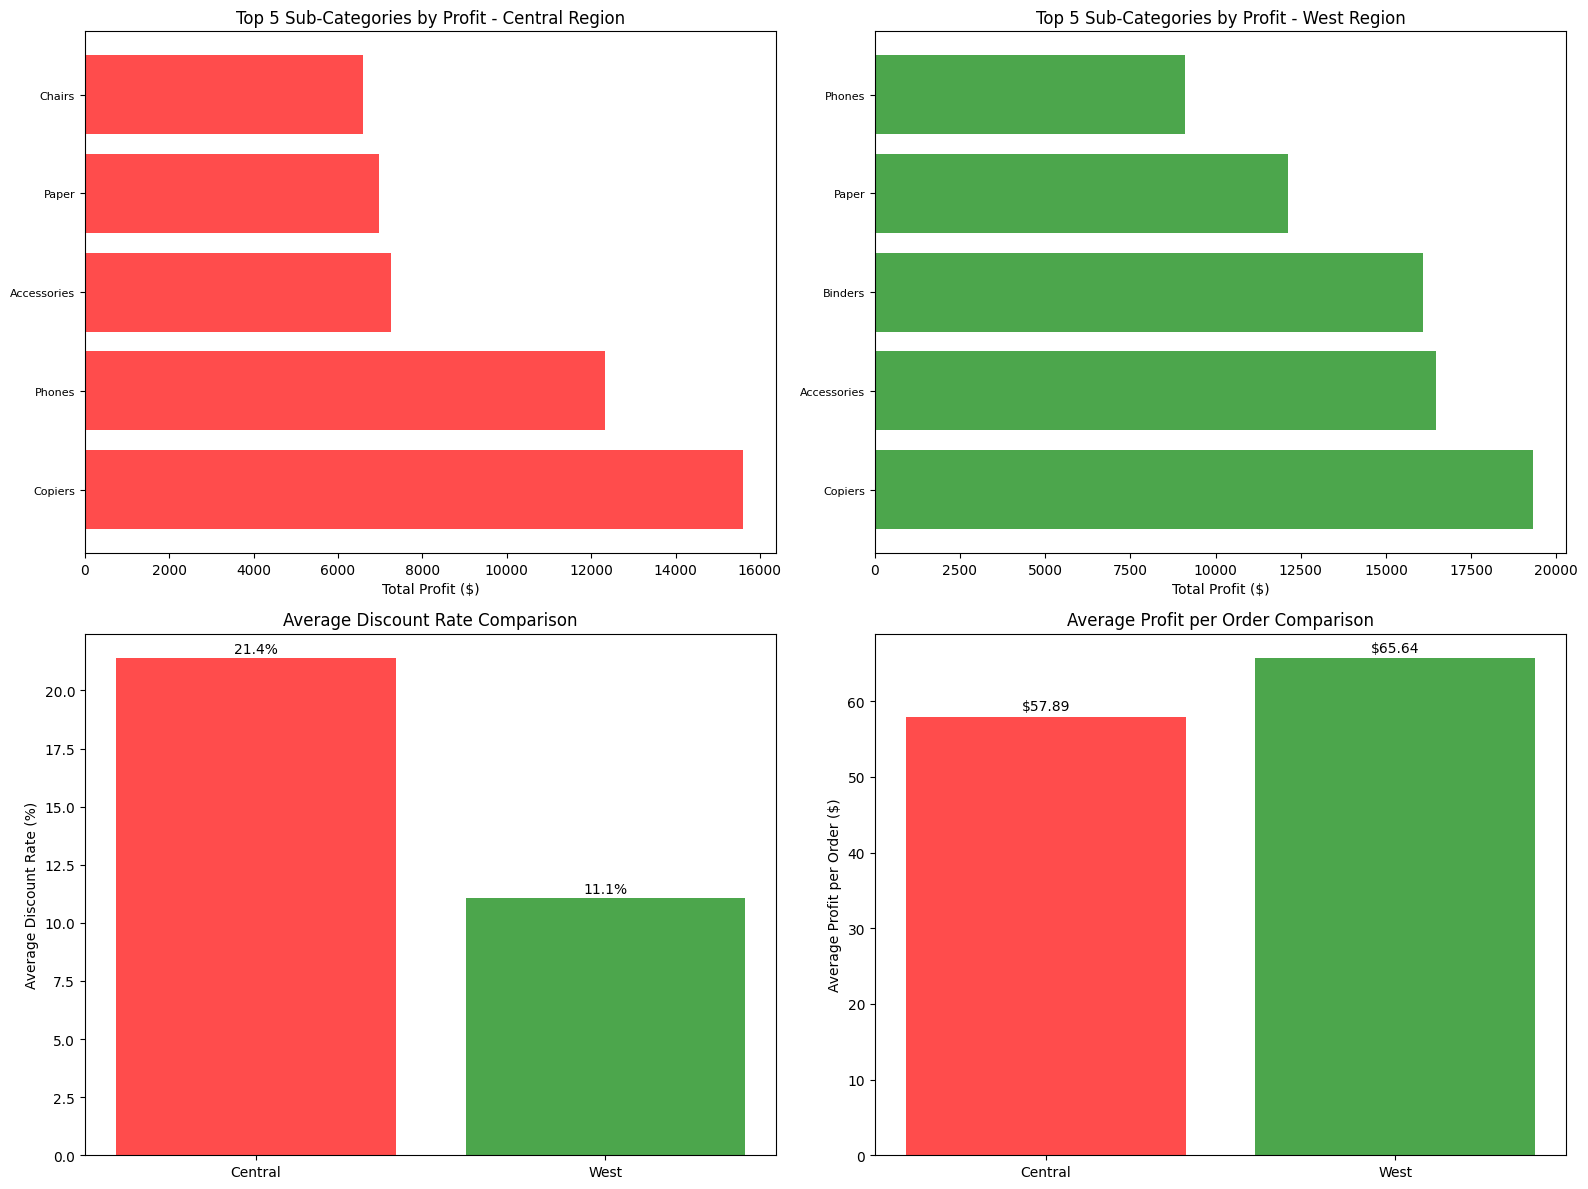

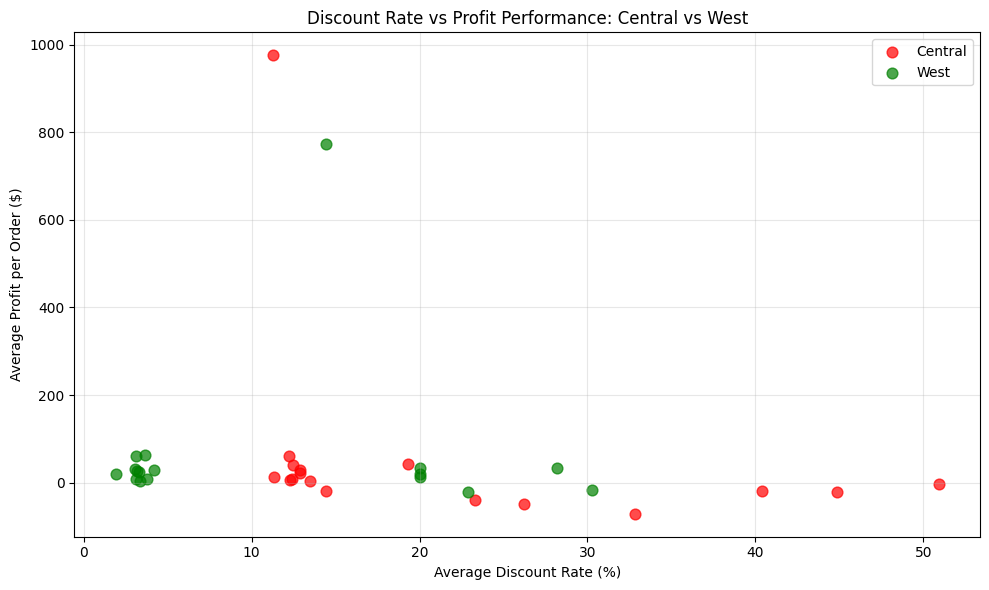

In [ ]:
# Compare Central vs. West

query_comparison = f"""
SELECT
    region,
    subcategory,
    SUM(sales) as total_sales,
    SUM(profit) as total_profit,
    AVG(discount) as avg_discount,
    COUNT(*) as orders,
    AVG(profit) as avg_profit_per_order
FROM `{table_id}`
WHERE region IN ('Central', 'West')
GROUP BY region, subcategory
ORDER BY region, total_profit DESC
"""

central_west_comparison = client.query(query_comparison).to_dataframe()

# Compare top performers
central_data = central_west_comparison[central_west_comparison['region'] == 'Central']
west_data = central_west_comparison[central_west_comparison['region'] == 'West']

# Compare average metrics
central_avg_discount = central_data['avg_discount'].mean()
west_avg_discount = west_data['avg_discount'].mean()
central_avg_profit = central_data['avg_profit_per_order'].mean()
west_avg_profit = west_data['avg_profit_per_order'].mean()


# Show performance gap
performance_gap = west_avg_profit - central_avg_profit

# Visualization 3: Central vs West Comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Top 5 sub-categories by profit for each region
central_top5 = central_data.head(5)
west_top5 = west_data.head(5)

# Sub-category profit comparison
ax1.barh(central_top5['subcategory'], central_top5['total_profit'],
         color='red', alpha=0.7, label='Central')
ax1.set_title('Top 5 Sub-Categories by Profit - Central Region')
ax1.set_xlabel('Total Profit ($)')
ax1.tick_params(axis='y', labelsize=8)

ax2.barh(west_top5['subcategory'], west_top5['total_profit'],
         color='green', alpha=0.7, label='West')
ax2.set_title('Top 5 Sub-Categories by Profit - West Region')
ax2.set_xlabel('Total Profit ($)')
ax2.tick_params(axis='y', labelsize=8)

# Average discount comparison
regions = ['Central', 'West']
avg_discounts = [central_avg_discount * 100, west_avg_discount * 100]
ax3.bar(regions, avg_discounts, color=['red', 'green'], alpha=0.7)
ax3.set_title('Average Discount Rate Comparison')
ax3.set_ylabel('Average Discount Rate (%)')
for i, v in enumerate(avg_discounts):
    ax3.text(i, v + 0.1, f'{v:.1f}%', ha='center', va='bottom')

# Average profit per order comparison
avg_profits = [central_avg_profit, west_avg_profit]
ax4.bar(regions, avg_profits, color=['red', 'green'], alpha=0.7)
ax4.set_title('Average Profit per Order Comparison')
ax4.set_ylabel('Average Profit per Order ($)')
for i, v in enumerate(avg_profits):
    ax4.text(i, v + 0.5, f'${v:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Scatter plot: Discount vs Profit Performance
plt.figure(figsize=(10, 6))
plt.scatter(central_data['avg_discount'] * 100, central_data['avg_profit_per_order'],
           color='red', alpha=0.7, s=60, label='Central')
plt.scatter(west_data['avg_discount'] * 100, west_data['avg_profit_per_order'],
           color='green', alpha=0.7, s=60, label='West')

plt.xlabel('Average Discount Rate (%)')
plt.ylabel('Average Profit per Order ($)')
plt.title('Discount Rate vs Profit Performance: Central vs West')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
# Regional Performance Dashboard

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Regional Sales Performance', 'Regional Profit Margins',
                   'Market Segment Distribution', 'Category Distribution'),
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "pie"}, {"type": "pie"}]]
)

# Regional Sales
regional_sales = df.groupby('region')['sales'].sum().sort_values(ascending=False)
fig.add_trace(
    go.Bar(x=regional_sales.index, y=regional_sales.values,
           name='Sales', marker_color='#1f77b4'),
    row=1, col=1
)

# Regional Profit Margins
regional_profit_margin = df.groupby('region').agg({'sales': 'sum', 'profit': 'sum'})
regional_profit_margin['Profit_Margin'] = (regional_profit_margin['profit'] / regional_profit_margin['sales'] * 100)
fig.add_trace(
    go.Bar(x=regional_profit_margin.index, y=regional_profit_margin['Profit_Margin'],
           name='Profit Margin %', marker_color='#ff7f0e'),
    row=1, col=2
)

# Market Segment Distribution
segment_sales = df.groupby('segment')['sales'].sum()
fig.add_trace(
    go.Pie(labels=segment_sales.index, values=segment_sales.values,
           name="Market Segments"),
    row=2, col=1
)

# Category Distribution
category_sales = df.groupby('category')['sales'].sum()
fig.add_trace(
    go.Pie(labels=category_sales.index, values=category_sales.values,
           name="Categories"),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title_text="<b>Regional Performance Overview</b>",
    title_x=0.5,
    height=800,
    showlegend=False
)

fig.update_xaxes(title_text="Region", row=1, col=1)
fig.update_yaxes(title_text="Sales ($)", row=1, col=1)
fig.update_xaxes(title_text="Region", row=1, col=2)
fig.update_yaxes(title_text="Profit Margin (%)", row=1, col=2)

fig.show()

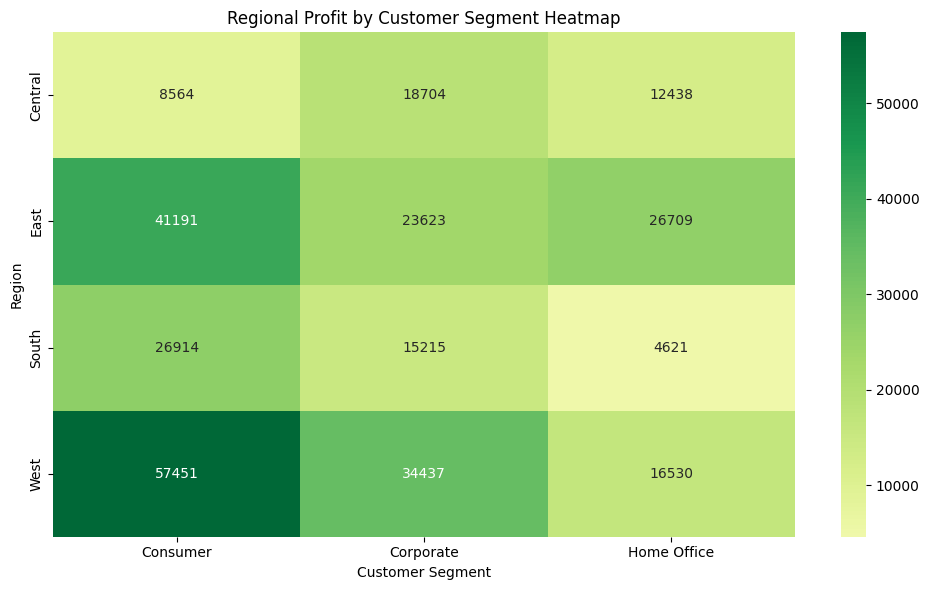

<Figure size 1200x600 with 0 Axes>

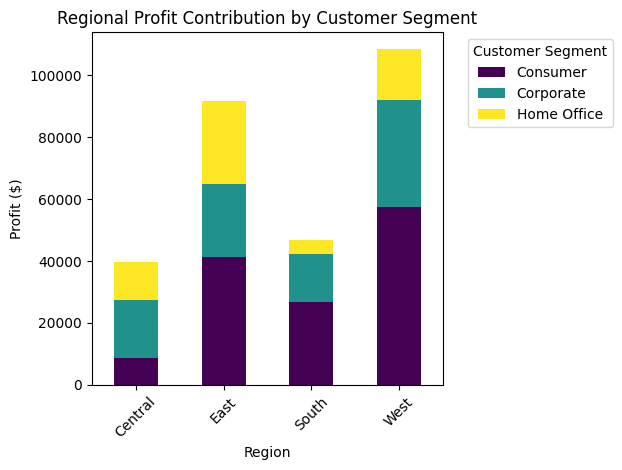

In [11]:
# Regional performance by customer segment
query_segment = f"""
SELECT
    region,
    segment,
    COUNT(*) as orders,
    SUM(sales) as segment_sales,
    SUM(profit) as segment_profit,
    AVG(profit_margin) as avg_margin,
    AVG(DATE_DIFF(ship_date, order_date, DAY)) as avg_ship_days
FROM `{table_id}`
GROUP BY region, segment
ORDER BY region, segment_profit DESC
"""

regional_segment = client.query(query_segment).to_dataframe()

# Create a pivot table for better visualization
segment_pivot = regional_segment.pivot(index='region', columns='segment', values='segment_profit')

# Visualization 1: Heatmap of segment performance
plt.figure(figsize=(10, 6))
import seaborn as sns
sns.heatmap(segment_pivot, annot=True, fmt='.0f', cmap='RdYlGn', center=0)
plt.title('Regional Profit by Customer Segment Heatmap')
plt.ylabel('Region')
plt.xlabel('Customer Segment')
plt.tight_layout()
plt.show()

# Visualization 2: Stacked bar chart
plt.figure(figsize=(12, 6))
segment_pivot.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Regional Profit Contribution by Customer Segment')
plt.xlabel('Region')
plt.ylabel('Profit ($)')
plt.legend(title='Customer Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

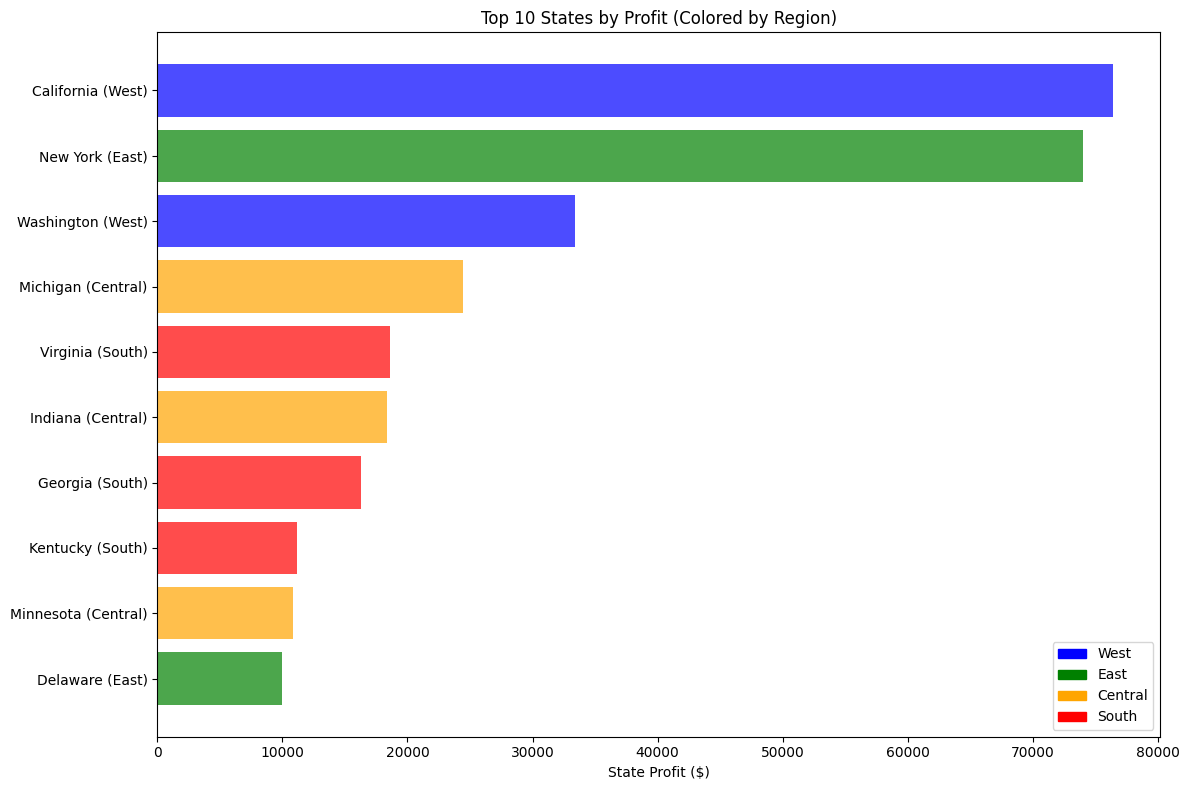

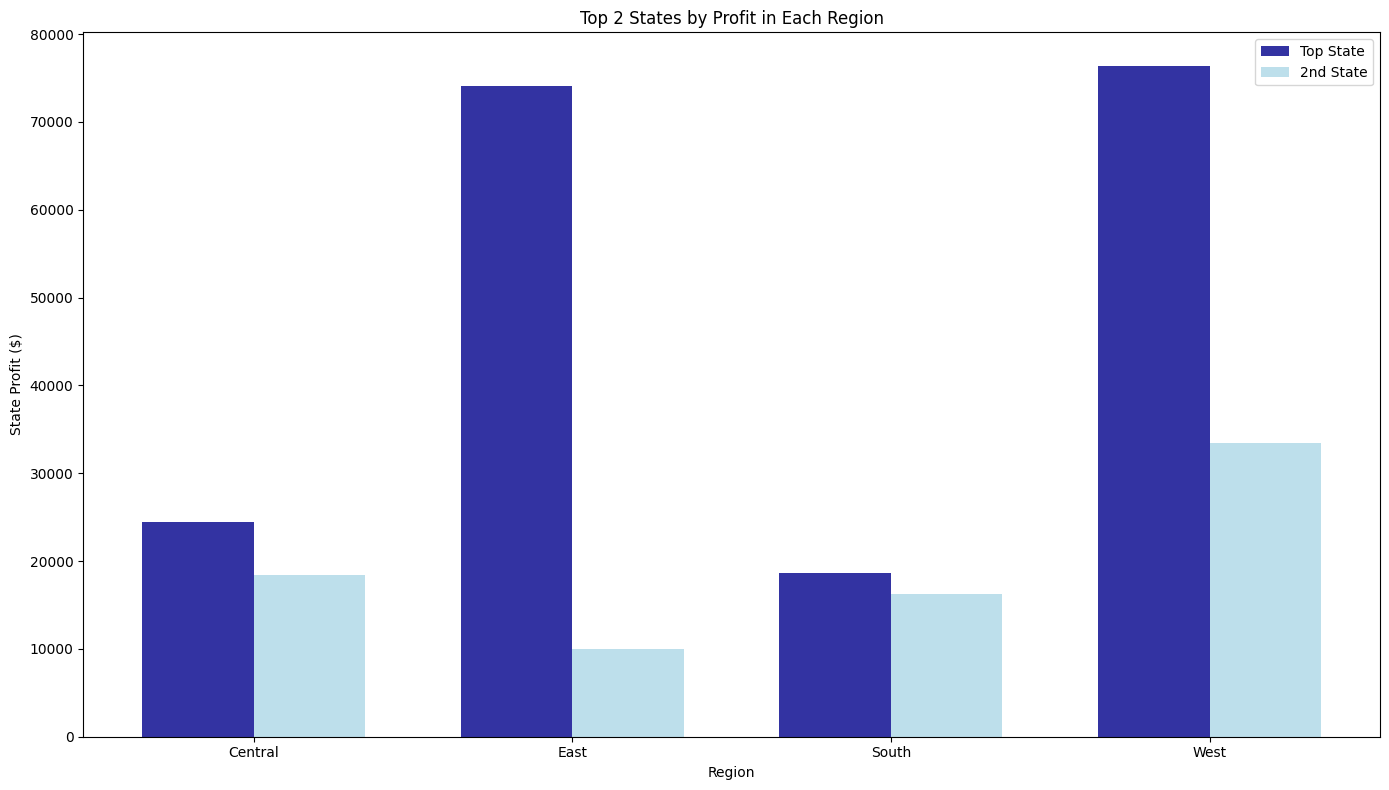

In [10]:
# Top performing states within regions
query_state = f"""
SELECT
    region,
    state,
    COUNT(*) as orders,
    SUM(sales) as state_sales,
    SUM(profit) as state_profit,
    AVG(profit_margin) as avg_margin
FROM `{table_id}`
GROUP BY region, state
ORDER BY region, state_profit DESC
"""

state_performance = client.query(query_state).to_dataframe()

for region in regional_basic['region']:
    region_states = state_performance[state_performance['region'] == region].head(3)

top_states_overall = state_performance.nlargest(10, 'state_profit')

# Visualization 3: Top 10 States Overall
plt.figure(figsize=(12, 8))
colors = {'West': 'blue', 'East': 'green', 'Central': 'orange', 'South': 'red'}
bar_colors = [colors[region] for region in top_states_overall.head(10)['region']]

plt.barh(range(len(top_states_overall.head(10))),
         top_states_overall.head(10)['state_profit'],
         color=bar_colors, alpha=0.7)

plt.yticks(range(len(top_states_overall.head(10))),
           [f"{row['state']} ({row['region']})" for _, row in top_states_overall.head(10).iterrows()])
plt.xlabel('State Profit ($)')
plt.title('Top 10 States by Profit (Colored by Region)')
plt.gca().invert_yaxis()

# Add legend for regions
import matplotlib.patches as mpatches
legend_elements = [mpatches.Patch(color=color, label=region) for region, color in colors.items()]
plt.legend(handles=legend_elements, loc='lower right')
plt.tight_layout()
plt.show()

# Visualization 4: Top 2 states per region comparison
plt.figure(figsize=(14, 8))
top_states_by_region = state_performance.groupby('region').head(2)

regions = top_states_by_region['region'].unique()
x_pos = np.arange(len(regions))
width = 0.35

first_states = top_states_by_region.groupby('region').nth(0)
second_states = top_states_by_region.groupby('region').nth(1)

plt.bar(x_pos - width/2, first_states['state_profit'], width,
        label='Top State', alpha=0.8, color='darkblue')
plt.bar(x_pos + width/2, second_states['state_profit'], width,
        label='2nd State', alpha=0.8, color='lightblue')

plt.xlabel('Region')
plt.ylabel('State Profit ($)')
plt.title('Top 2 States by Profit in Each Region')
plt.xticks(x_pos, regions)
plt.legend()
plt.tight_layout()
plt.show()


In [13]:
findings_summary = f"""
INVESTIGATION FINDINGS:

1. REGIONAL PERFORMANCE RANKING:
{regional_basic.to_string(index=False)}

2. CUSTOMER SEGMENT PERFORMANCE:
{segment_pivot.to_string()}

3. TOP STATES BY REGION:
{top_states_overall.head(8)[['region', 'state', 'state_profit']].to_string(index=False)}
"""

# Generate hypotheses with Gemini
prompt_hypotheses = f"""
As a business analyst, I've investigated regional performance patterns in a Superstore dataset. Here are my findings:

{findings_summary}

Based on these investigation results, please generate 3 data-driven hypotheses about WHY these regional performance differences exist.

Focus on operational, geographic, and market factors that could explain these patterns.
"""

#print("Gemini Hypothesis")
#print("=" * 50)
#response_hypotheses = model.generate_content(prompt_hypotheses)
#print(response_hypotheses.text)
#print("=" * 50)


### Gemini Hypothesis:
Excellent. Based on your detailed investigation findings, here are 3 data-driven hypotheses that explore the potential operational, geographic, and market factors behind the regional performance differences.

---

### **Executive Summary**

The analysis reveals a clear performance hierarchy: West and East are high-performing, South is a moderate performer, and Central is a significant underperformer, particularly in profitability per order. The following hypotheses propose explanations for these disparities, focusing on the interplay between market concentration, product strategy, and customer segment focus.

---

### **3 Data-Driven Hypotheses**

#### **Hypothesis 1: The "Economic Hub" Effect**
*The disproportionately high profits in the West and East are driven by the concentration of business in major economic hubs (like California and New York), which host a higher density of high-value corporate clients and affluent consumers who purchase higher-margin products.*

*   **Supporting Data:**
    *   **Finding #1:** The West and East have the highest average profit per order ($33.85 and $32.14, respectively).
    *   **Finding #3:** California and New York alone account for a massive portion of their regions' profits (CA: $76k of $108k West profit; NY: $74k of $91.5k East profit).
    *   **Finding #2:** The West and East dominate in the Corporate and Home Office segments, which typically represent higher-value, more profitable orders than the general Consumer segment.

*   **Potential Explanation (Geographic & Market Factors):**
    States like California (Silicon Valley) and New York (Financial District) are home to a vast number of large corporations and a thriving "prosumer"/Home Office market. These customers are likely purchasing more expensive items (e.g., high-end office chairs, advanced technology) in larger quantities, leading to a much healthier profit margin per order. The business effectively succeeds by winning in these key, dense markets.

*   **Next Steps for Validation:**
    *   Analyze the product categories sold in CA and NY versus other states.
    *   Compare the Average Order Value (AOV) for Corporate customers in the West vs. other regions.

#### **Hypothesis 2: The "Central" Problem - Margin Erosion**
*The Central region's poor performance, specifically its extremely low average profit per order, is caused by a less profitable product mix and/or a more aggressive pricing and discount strategy, likely driven by local market competition or a different customer demographic.*

*   **Supporting Data:**
    *   **Finding #1:** The Central region has the lowest average profit per order ($17.09), which is nearly **half** that of the West and East.
    *   **Finding #1:** Despite having the second-highest number of orders (2,323), the Central region has the lowest total profit ($39,706). This indicates a systemic issue with profitability on each sale, not a lack of sales activity.
    *   **Finding #2:** The Consumer segment profit in the Central region ($8,564) is drastically lower than in other regions, suggesting the bulk of its high order volume may come from low-margin consumer sales.

*   **Potential Explanation (Operational & Market Factors):**
    The Central region may face more price-sensitive competition, forcing the use of heavy discounts to win sales. Alternatively, the product mix being sold might be skewed towards lower-margin categories (e.g., office supplies vs. technology). This operational choice (or market necessity) erodes profit on every transaction, leading to a high-volume, low-profit scenario.

*   **Next Steps for Validation:**
    *   Analyze the average discount rate applied to orders in the Central region compared to others.
    *   Drill down into the profitability of specific product sub-categories within the Central region.

#### **Hypothesis 3: The "Segment Strategy" Mismatch**
*Regional performance variations are influenced by how well the regional sales and marketing strategies align with the dominant customer segments in that area. The East's success, for example, is amplified by a strong focus on the Home Office segment, while the South may be underperforming in that same area.*

*   **Supporting Data:**
    *   **Finding #2:** The East's profit from the Home Office segment ($26,709) is its strongest category, even outperforming its Corporate segment. This is a unique pattern not seen elsewhere.
    *   **Finding #2:** In stark contrast, the South has the lowest profit from the Home Office segment ($4,620) of any region.
    *   **Finding #2:** The West demonstrates a balanced strength but leads significantly in the broad Consumer segment ($57,450), suggesting a successful mass-market approach.

*   **Potential Explanation (Operational & Market Factors):**
    These differences suggest tailored (or untailored) regional strategies. The East's sales team might be specifically trained or incentivized to target and serve home-based professionals, a strong demographic in that region. Conversely, the South's marketing and sales efforts might be more focused on general consumers, thereby missing opportunities with potentially lucrative Home Office or Corporate clients. This isn't just about the market existing, but about the operational focus to capture it.

*   **Next Steps for Validation:**
    *   Investigate if there are region-specific marketing campaigns targeting different segments.
    *   Interview regional sales managers to understand their strategic priorities and team structure.

In [14]:
# Validate Hypothesis 1: The "Economic Hub" Effect

# Query 1a: Product categories sold in CA and NY vs other states
query_economic_hubs = f"""
SELECT
    state,
    region,
    category,
    SUM(profit) as category_profit,
    COUNT(*) as orders,
    AVG(profit) as avg_profit_per_order,
    SUM(sales) as total_sales,
    AVG(sales) as avg_order_value
FROM `{table_id}`
WHERE state IN ('California', 'New York') OR region IN ('Central', 'South')
GROUP BY state, region, category
ORDER BY state, category_profit DESC
"""

economic_hubs_data = client.query(query_economic_hubs).to_dataframe()
print("Product Category Performance in Economic Hubs (CA, NY) vs Other Regions:")
print("=" * 70)
print(economic_hubs_data.to_string(index=False))

Product Category Performance in Economic Hubs (CA, NY) vs Other Regions:
         state  region        category  category_profit  orders  avg_profit_per_order  total_sales  avg_order_value
       Alabama   South      Technology        3297.8029      14            235.557350    8969.0800       640.648571
       Alabama   South Office Supplies        1257.6342      36             34.934283    4209.0800       116.918889
       Alabama   South       Furniture        1231.3882      11            111.944382    6332.4800       575.680000
      Arkansas   South Office Supplies        1965.7935      36             54.605375    4565.3300       126.814722
      Arkansas   South      Technology        1261.4384      15             84.095893    3925.2500       261.683333
      Arkansas   South       Furniture         781.4552       9             86.828356    3187.5500       354.172222
    California    West Office Supplies       37748.3847    1198             31.509503  142351.9480       118.824664

In [15]:
# Query 1b: Average Order Value (AOV) for Corporate customers by region
query_corporate_aov = f"""
SELECT
    region,
    segment,
    COUNT(*) as orders,
    SUM(sales) as total_sales,
    AVG(sales) as avg_order_value,
    SUM(profit) as total_profit,
    AVG(profit) as avg_profit_per_order,
    AVG(profit/sales) as profit_margin
FROM `{table_id}`
WHERE segment = 'Corporate'
GROUP BY region, segment
ORDER BY avg_order_value DESC
"""

corporate_aov_data = client.query(query_corporate_aov).to_dataframe()
print("\\nCorporate Customer Performance by Region:")
print("=" * 50)
print(corporate_aov_data.to_string(index=False))

\nCorporate Customer Performance by Region:
 region   segment  orders  total_sales  avg_order_value  total_profit  avg_profit_per_order  profit_margin
  South Corporate     510  121885.9325       238.992025    15215.2232             29.833771       0.152866
   West Corporate     960  225855.2745       235.265911    34437.4299             35.872323       0.217898
Central Corporate     673  157995.8128       234.763466    18703.9020             27.791831      -0.083553
   East Corporate     877  200409.3470       228.516929    23622.5789             26.935666       0.154070


In [16]:
# Gemini Analysis of Hypothesis 1 Results

prompt_hypothesis1_analysis = f"""
Hypothesis 1: The "Economic Hub" Effect
The disproportionately high profits in the West and East are driven by the concentration of business in major economic hubs (like California and New York), which host a higher density of high-value corporate clients and affluent consumers who purchase higher-margin products.

Supporting Data:

Finding #1: The West and East have the highest average profit per order ($33.85 and $32.14, respectively).
Finding #3: California and New York alone account for a massive portion of their regions' profits (CA: $76k of $108k West profit; NY: $74k of $91.5k East profit).
Finding #2: The West and East dominate in the Corporate and Home Office segments, which typically represent higher-value, more profitable orders than the general Consumer segment.
Potential Explanation (Geographic & Market Factors): States like California (Silicon Valley) and New York (Financial District) are home to a vast number of large corporations and a thriving "prosumer"/Home Office market. These customers are likely purchasing more expensive items (e.g., high-end office chairs, advanced technology) in larger quantities, leading to a much healthier profit margin per order. The business effectively succeeds by winning in these key, dense markets.

**ACTUAL QUERY RESULTS:**

**Query 1a - Product Categories in Economic Hubs vs Other Regions:**
{economic_hubs_data.to_string(index=False)}

**Query 1b - Corporate Customer Performance by Region:**
{corporate_aov_data.to_string(index=False)}

**ANALYSIS REQUEST:**
As a business analyst, please analyze these actual query results against the "Economic Hub" hypothesis.
Use your expertise to determine what aspects are most important to examine and draw conclusions.
Provide a comprehensive analysis of whether this hypothesis holds up based on the data evidence.
"""

response_hypothesis1 = model.generate_content(prompt_hypothesis1_analysis)
print(response_hypothesis1.text)


Okay, let's analyze the query results and assess the validity of the "Economic Hub" hypothesis.

**Key Aspects to Examine:**

*   **Profit and Order Value Comparison:**  We need to compare the profit per order and average order value across regions and product categories.  Are the West and East consistently higher than the other regions?
*   **Dominance in Corporate/Home Office Segments:** Does the West and East's dominance in these segments translate to significantly higher profit margins within those segments, especially compared to other regions?
*   **Product Category Profit Contributions:** Are the high profits in the West and East driven by specific, high-margin product categories like Technology?  Is this pattern less pronounced in other regions?
*   **Impact of Individual States (CA & NY):** Are the profits from CA and NY significantly higher than other states within their respective regions, and do they skew the regional averages?
*   **Negative Profitability:** Note any insta

In [17]:
# Validate Hypothesis 2: The "Central" Problem - Margin Erosion

# Query 2a: Average discount rates by region
query_discount_analysis = f"""
SELECT
    region,
    COUNT(*) as total_orders,
    AVG(discount) as avg_discount_rate,
    SUM(CASE WHEN discount > 0 THEN 1 ELSE 0 END) as discounted_orders,
    (SUM(CASE WHEN discount > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)) as discount_order_percentage,
    AVG(profit) as avg_profit_per_order,
    AVG(sales) as avg_sales_per_order,
    AVG(profit/sales) as profit_margin
FROM `{table_id}`
GROUP BY region
ORDER BY avg_discount_rate DESC
"""

discount_analysis_data = client.query(query_discount_analysis).to_dataframe()
print("Discount Strategy Analysis by Region:")
print("=" * 40)
print(discount_analysis_data.to_string(index=False))


Discount Strategy Analysis by Region:
 region  total_orders  avg_discount_rate  discounted_orders  discount_order_percentage  avg_profit_per_order  avg_sales_per_order  profit_margin
Central          2323           0.240353               1495                  64.356436             17.092709           215.772661      -0.104073
  South          1620           0.147253                815                  50.308642             28.857673           241.803645       0.163519
   East          2848           0.145365               1399                  49.122191             32.135808           238.336110       0.167227
   West          3203           0.109335               1487                  46.425226             33.849032           226.493233       0.219487


In [18]:
# Query 2b: Product mix profitability by region (focus on Central)
query_product_mix = f"""
SELECT
    region,
    category,
    subcategory,
    COUNT(*) as orders,
    SUM(profit) as total_profit,
    AVG(profit) as avg_profit_per_order,
    SUM(sales) as total_sales,
    AVG(profit/sales) as profit_margin,
    -- Calculate percentage of regional orders
    (COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY region)) as pct_of_regional_orders
FROM `{table_id}`
WHERE region = 'Central'
GROUP BY region, category, subcategory
ORDER BY total_profit DESC
"""

product_mix_data = client.query(query_product_mix).to_dataframe()
print("\\nProduct Mix Analysis - Central Region:")
print("=" * 45)
print(product_mix_data.to_string(index=False))


\nProduct Mix Analysis - Central Region:
 region        category subcategory  orders  total_profit  avg_profit_per_order  total_sales  profit_margin  pct_of_regional_orders
Central      Technology     Copiers      16    15608.8413            975.552581   37259.5700       0.370469                0.688765
Central      Technology      Phones     200    12323.0267             61.615134   72403.2820       0.166875                8.609557
Central      Technology Accessories     183     7251.6306             39.626397   33956.0760       0.183893                7.877744
Central Office Supplies       Paper     321     6971.9005             21.719316   17491.9020       0.390397               13.818338
Central       Furniture      Chairs     154     6592.7221             42.809884   85230.6460       0.004443                6.629359
Central Office Supplies     Storage     210     1969.8365              9.380174   45930.1120       0.041786                9.040034
Central Office Supplies   Envelopes

In [19]:
# Gemini Analysis of Hypothesis 2 Results

prompt_hypothesis2_analysis = f"""
Hypothesis 2: The "Central" Problem - Margin Erosion
The Central region's poor performance, specifically its extremely low average profit per order, is caused by a less profitable product mix and/or a more aggressive pricing and discount strategy, likely driven by local market competition or a different customer demographic.

Supporting Data:

Finding #1: The Central region has the lowest average profit per order ($17.09), which is nearly half that of the West and East.
Finding #1: Despite having the second-highest number of orders (2,323), the Central region has the lowest total profit ($39,706). This indicates a systemic issue with profitability on each sale, not a lack of sales activity.
Finding #2: The Consumer segment profit in the Central region ($8,564) is drastically lower than in other regions, suggesting the bulk of its high order volume may come from low-margin consumer sales.
Potential Explanation (Operational & Market Factors): The Central region may face more price-sensitive competition, forcing the use of heavy discounts to win sales. Alternatively, the product mix being sold might be skewed towards lower-margin categories (e.g., office supplies vs. technology). This operational choice (or market necessity) erodes profit on every transaction, leading to a high-volume, low-profit scenario.

**ACTUAL QUERY RESULTS:**

**Query 2a - Discount Strategy Analysis by Region:**
{discount_analysis_data.to_string(index=False)}

**Query 2b - Product Mix Analysis - Central Region:**
{product_mix_data.to_string(index=False)}

**ANALYSIS REQUEST:**
As a business analyst, please analyze these actual query results against the "Central Problem - Margin Erosion" hypothesis.
Use your expertise to determine what aspects are most important to examine and draw conclusions.
Provide a comprehensive analysis of whether this hypothesis holds up based on the data evidence.
"""

response_hypothesis2 = model.generate_content(prompt_hypothesis2_analysis)
print(response_hypothesis2.text)


Okay, let's analyze the query results to evaluate the "Central Problem - Margin Erosion" hypothesis.  We'll break down the analysis into key areas and then draw a conclusion.

**Key Areas of Analysis:**

1.  **Discount Strategy:** Does the Central region indeed have a more aggressive discount strategy compared to other regions?

2.  **Product Mix:** Is the product mix in the Central region skewed towards lower-margin categories, and are there any unusually high-volume/low-profit categories?

3.  **Specific Category Performance:** Are there specific product categories in the Central region driving down overall profitability?

4.  **Profit Margin Comparison:** How does the profit margin (profit/sales) compare across regions?

**Analysis Based on Query Results:**

**1. Discount Strategy (Query 2a):**

*   The data strongly supports this aspect of the hypothesis. The Central region's average discount rate is significantly higher (24.04%) than other regions:
    *   South: 14.73%
    *   Ea

In [20]:
# Query 3a: Customer segment performance patterns by region
query_segment_analysis = f"""
SELECT
    region,
    segment,
    COUNT(*) as orders,
    SUM(profit) as total_profit,
    AVG(profit) as avg_profit_per_order,
    SUM(sales) as total_sales,
    AVG(sales) as avg_order_value,
    AVG(profit/sales) as profit_margin,
    -- Calculate percentage of regional profit
    (SUM(profit) * 100.0 / SUM(SUM(profit)) OVER (PARTITION BY region)) as pct_of_regional_profit
FROM `{table_id}`
GROUP BY region, segment
ORDER BY region, total_profit DESC
"""

segment_analysis_data = client.query(query_segment_analysis).to_dataframe()
print("Customer Segment Performance by Region:")
print("=" * 45)
print(segment_analysis_data.to_string(index=False))

Customer Segment Performance by Region:
 region     segment  orders  total_profit  avg_profit_per_order  total_sales  avg_order_value  profit_margin  pct_of_regional_profit
Central   Corporate     673    18703.9020             27.791831  157995.8128       234.763466      -0.083553               47.105554
Central Home Office     438    12438.4124             28.398202   91212.6440       208.248046      -0.031633               31.325993
Central    Consumer    1212     8564.0481              7.066046  252031.4340       207.946728      -0.141646               21.568453
   East    Consumer    1469    41190.9843             28.040153  350908.1670       238.875539       0.167773               45.006264
   East Home Office     502    26709.2168             53.205611  127463.7260       253.911805       0.188615               29.183135
   East   Corporate     877    23622.5789             26.935666  200409.3470       228.516929       0.154070               25.810600
  South    Consumer     838  

In [21]:
# Query 3b: Home Office segment deep dive (East success vs South underperformance)
query_home_office_analysis = f"""
SELECT
    region,
    segment,
    category,
    COUNT(*) as orders,
    SUM(profit) as total_profit,
    AVG(profit) as avg_profit_per_order,
    SUM(sales) as total_sales,
    AVG(sales) as avg_order_value,
    AVG(profit/sales) as profit_margin
FROM `{table_id}`
WHERE segment = 'Home Office'
GROUP BY region, segment, category
ORDER BY region, total_profit DESC
"""

home_office_analysis_data = client.query(query_home_office_analysis).to_dataframe()
print("\\nHome Office Segment Analysis by Region and Category:")
print("=" * 55)
print(home_office_analysis_data.to_string(index=False))


\nHome Office Segment Analysis by Region and Category:
 region     segment        category  orders  total_profit  avg_profit_per_order  total_sales  avg_order_value  profit_margin
Central Home Office      Technology      83     7439.4796             89.632284   32953.0660       397.024892       0.196053
Central Home Office Office Supplies     266     6197.5419             23.299030   32777.2350       123.222688      -0.048164
Central Home Office       Furniture      89    -1198.6091            -13.467518   25482.3430       286.318461      -0.194560
   East Home Office      Technology      98    17709.0675            180.704770   59807.1860       610.277408       0.170867
   East Home Office Office Supplies     304     8334.2214             27.415202   37786.1840       124.296658       0.225318
   East Home Office       Furniture     100      665.9279              6.659279   29870.3560       298.703560       0.094433
  South Home Office Office Supplies     166     2653.6160             

In [22]:
# Gemini Analysis of Hypothesis 3 Results
prompt_hypothesis3_analysis = f"""
Hypothesis 3: The "Segment Strategy" Mismatch
Regional performance variations are influenced by how well the regional sales and marketing strategies align with the dominant customer segments in that area. The East's success, for example, is amplified by a strong focus on the Home Office segment, while the South may be underperforming in that same area.

Supporting Data:

Finding #2: The East's profit from the Home Office segment ($26,709) is its strongest category, even outperforming its Corporate segment. This is a unique pattern not seen elsewhere.
Finding #2: In stark contrast, the South has the lowest profit from the Home Office segment ($4,620) of any region.
Finding #2: The West demonstrates a balanced strength but leads significantly in the broad Consumer segment ($57,450), suggesting a successful mass-market approach.
Potential Explanation (Operational & Market Factors): These differences suggest tailored (or untailored) regional strategies. The East's sales team might be specifically trained or incentivized to target and serve home-based professionals, a strong demographic in that region. Conversely, the South's marketing and sales efforts might be more focused on general consumers, thereby missing opportunities with potentially lucrative Home Office or Corporate clients. This isn't just about the market existing, but about the operational focus to capture it.

**ACTUAL QUERY RESULTS:**

**Query 3a - Customer Segment Performance by Region:**
{segment_analysis_data.to_string(index=False)}

**Query 3b - Home Office Segment Analysis by Region and Category:**
{home_office_analysis_data.to_string(index=False)}

**ANALYSIS REQUEST:**
As a business analyst, please analyze these actual query results against the "Segment Strategy Mismatch" hypothesis.
Use your expertise to determine what aspects are most important to examine and draw conclusions.
Provide a comprehensive analysis of whether this hypothesis holds up based on the data evidence.
"""

response_hypothesis3 = model.generate_content(prompt_hypothesis3_analysis)
print(response_hypothesis3.text)


Okay, here's a comprehensive analysis of Hypothesis 3 (Segment Strategy Mismatch) based on the provided data.

**Hypothesis 3: The "Segment Strategy" Mismatch**

*   *Regional performance variations are influenced by how well the regional sales and marketing strategies align with the dominant customer segments in that area. The East's success, for example, is amplified by a strong focus on the Home Office segment, while the South may be underperforming in that same area.*

**Data Review & Key Considerations:**

Before jumping to conclusions, let's outline what we're looking for:

*   **Regional Variations in Segment Performance:** We want to see if profits and sales from specific segments are disproportionately high or low in certain regions.
*   **Comparison of Segment Contribution to Regional Profit:** How big a piece of the pie does each segment contribute to overall regional profitability?  This highlights strategic emphasis (or lack thereof).
*   **Segment Profitability:**  Is a r

In [23]:
# Combine all validated hypothesis insights for strategic planning
strategic_prompt = f"""
I need to transform these validated regional analysis insights into actionable business strategies.

**HYPOTHESIS 1 ANALYSIS - Economic Hub Effect:**
{response_hypothesis1.text}

**HYPOTHESIS 2 ANALYSIS - Central Problem Margin Erosion:**
{response_hypothesis2.text}

**HYPOTHESIS 3 ANALYSIS - Segment Strategy Mismatch:**
{response_hypothesis3.text}


Based on these validated insights, what should the business do? How can we measure impact? What are the risks?

Transform these findings into a comprehensive strategic action plan that executives can implement across regional operations.
"""

# Generate Gemini's strategic response
response_strategic_plan = model.generate_content(strategic_prompt)
print(response_strategic_plan.text)
print("=" * 80)


## Strategic Action Plan: Optimizing Regional Performance Based on Validated Insights

This strategic action plan outlines the steps necessary to address the key findings of the regional analysis and maximize overall profitability. It focuses on leveraging the "Economic Hub" effect, rectifying the "Central Problem - Margin Erosion," and aligning strategies with dominant customer segments as identified in the "Segment Strategy Mismatch" hypothesis.

**I. Executive Summary**

The company's regional performance is significantly influenced by three key factors: the concentration of economic activity in specific hubs (CA & NY), margin erosion challenges in the Central region, and misalignment between regional sales strategies and dominant customer segments. This plan addresses these factors through targeted interventions, knowledge sharing, and performance monitoring, aiming for a significant increase in overall profitability.

**II. Strategic Pillars**

This plan is built on three strategi